In [1]:
# ==================================================================================
# 1. SETUP & REPRODUCIBILITY
# ==================================================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress messy warnings for cleaner output
warnings.filterwarnings('ignore') 

# Deep Learning (PyTorch) - For Image Stream (Disease Detection)
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image

# Machine Learning (Scikit-Learn) - For Tabular Stream (Crop Recommendation)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Boosting & Explainability
import xgboost as xgb
import lightgbm as lgb
import lime
import lime.lime_tabular

# ----------------------------------------------------------------------------------
# CONFIGURATION
# ----------------------------------------------------------------------------------
DATA_PATH = 'Crop_recommendation.csv'  # The valid dataset
MODEL_DIR = 'models'                   # Where to save trained models
IMG_DIR = 'plots'                      # Where to save graphs

# Ensure directories exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(IMG_DIR, exist_ok=True)

# ----------------------------------------------------------------------------------
# DEVICE & SEED SETUP
# ----------------------------------------------------------------------------------
# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Hardware Detected: {device}")

# Reproducibility Seed
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)
print("✅ Random Seed Set (42)")

✅ Hardware Detected: cuda
✅ Random Seed Set (42)


In [3]:
# ==================================================================================
# 2. VISION STREAM: EFFICIENTNET-V2
# ==================================================================================
import platform  # <--- Added this missing import
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import numpy as np

# Configuration for this stream
SOIL_DATA_PATH = "DataSet/Soil Images"  # Path to your local image folder
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-4

# Check if image data exists before proceeding
if os.path.exists(SOIL_DATA_PATH):
    print(f"✅ Image Dataset found at: {SOIL_DATA_PATH}")
    
    # --- 1. System Optimization ---
    SYSTEM_OS = platform.system()
    if SYSTEM_OS == 'Windows':
        NUM_WORKERS = 0
        PIN_MEMORY = False
        print("💻 Windows detected: Using single-process loading (Safest)")
    else:
        NUM_WORKERS = min(4, os.cpu_count())
        PIN_MEMORY = True
        print("🚀 Linux/Mac detected: Using multi-process loading (Fastest)")

    # --- 2. Augmentation Pipelines ---
    transform_train = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    ])

    transform_val = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.255])
    ])

    # --- 3. Data Loading & Splitting ---
    try:
        # Load full dataset twice to apply different transforms
        full_dataset_train = datasets.ImageFolder(root=SOIL_DATA_PATH, transform=transform_train)
        full_dataset_val = datasets.ImageFolder(root=SOIL_DATA_PATH, transform=transform_val)

        # Get indices for split
        num_data = len(full_dataset_train)
        indices = list(range(num_data))
        split = int(np.floor(0.2 * num_data)) # 20% Validation

        # Shuffle
        np.random.seed(42)
        np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]

        # Create Subsets
        train_data = Subset(full_dataset_train, train_indices)
        val_data = Subset(full_dataset_val, val_indices)

        # Create Loaders
        train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, 
                                num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
        val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, 
                                num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
        
        soil_classes = full_dataset_train.classes
        print(f"🌿 Soil Classes: {soil_classes}")
        print(f"📈 Images: {len(train_data)} Train | {len(val_data)} Val")

        # --- 4. Model Setup (EfficientNet V2) ---
        print("🛠️ Initializing EfficientNet-V2...")
        cnn_model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        
        # Modify the final classification layer
        num_ftrs = cnn_model.classifier[1].in_features
        cnn_model.classifier[1] = nn.Linear(num_ftrs, len(soil_classes))
        
        cnn_model = cnn_model.to(device)
        
        # Loss & Optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(cnn_model.parameters(), lr=LR)

        # --- 5. Training Loop ---
        def train_vision_model():
            best_acc = 0.0
            print("📷 Starting Vision Training...")
            
            for epoch in range(EPOCHS):
                cnn_model.train()
                running_loss = 0.0
                
                for imgs, labels in train_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = cnn_model(imgs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    
                # Validation Phase
                cnn_model.eval()
                correct = 0; total = 0
                with torch.no_grad():
                    for imgs, labels in val_loader:
                        imgs, labels = imgs.to(device), labels.to(device)
                        outputs = cnn_model(imgs)
                        _, preds = torch.max(outputs, 1)
                        total += labels.size(0)
                        correct += (preds == labels).sum().item()
                
                val_acc = 100 * correct / total
                avg_loss = running_loss / len(train_loader)
                print(f"   Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.2f}%")
                
                # Save Best Model
                if val_acc > best_acc:
                    best_acc = val_acc
                    save_path = os.path.join(MODEL_DIR, 'soil_classifier_efficientnet.pth')
                    torch.save(cnn_model.state_dict(), save_path)
                    print(f"   💾 Best Model Saved to {save_path}")

        # Execute Training
        train_vision_model()

    except Exception as e:
        print(f"❌ Error during Vision Training: {e}")

else:
    # Graceful Fallback if data is missing
    print("⚠️  'DataSet/Soil Images' folder not found.")
    print("ℹ️  Skipping Vision Stream (Model will rely on Tabular Data only).")

✅ Image Dataset found at: DataSet/Soil Images
💻 Windows detected: Using single-process loading (Safest)
🌿 Soil Classes: ['Alluvial_Soil', 'Arid_Soil', 'Black_Soil', 'Laterite_Soil', 'Mountain_Soil', 'Red_Soil', 'Yellow_Soil']
📈 Images: 4078 Train | 1019 Val
🛠️ Initializing EfficientNet-V2...
📷 Starting Vision Training...
   Epoch 1/5 | Loss: 0.5905 | Val Acc: 97.64%
   💾 Best Model Saved to models\soil_classifier_efficientnet.pth
   Epoch 2/5 | Loss: 0.1475 | Val Acc: 98.23%
   💾 Best Model Saved to models\soil_classifier_efficientnet.pth
   Epoch 3/5 | Loss: 0.0957 | Val Acc: 97.55%
   Epoch 4/5 | Loss: 0.0545 | Val Acc: 97.25%
   Epoch 5/5 | Loss: 0.0564 | Val Acc: 98.23%



📊 Loading Tabular Data...
✅ Valid Data Loaded Successfully
   Shape: (2200, 8)
   Crops: ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']

🚀 Training Tabular Models...
   🔹 Random Forest   | Test Accuracy: 99.32%
   🔹 XGBoost         | Test Accuracy: 98.86%
   🔹 LightGBM        | Test Accuracy: 98.86%
   🔹 SVM             | Test Accuracy: 98.18%

🌟 Training Final Ensemble...
   🏆 ENSEMBLE (Final)  | Test Accuracy: 99.77%
📈 Accuracy graph saved to 'plots\tabular_model_accuracy.png'
💾 Models saved in 'models/' folder.


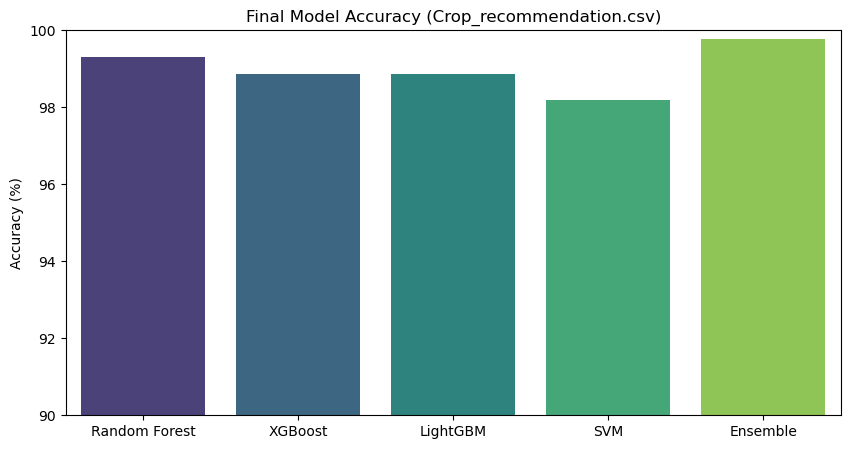

In [5]:
# ==================================================================================
# 3. TABULAR STREAM: CROP RECOMMENDATION (ENSEMBLE)
# ==================================================================================
import pickle  # <--- CRITICAL FIX: Importing pickle for saving models
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
# --- 1. Load Data ---
print("\n📊 Loading Tabular Data...")

# Use the DATA_PATH defined in Part 1 (or fallback to local 'DataSet' folder)
csv_path = DATA_PATH if os.path.exists(DATA_PATH) else 'DataSet/Crop_recommendation.csv'

try:
    crop_df = pd.read_csv(csv_path)
    print("✅ Valid Data Loaded Successfully")
    print(f"   Shape: {crop_df.shape}")
    print(f"   Crops: {crop_df['label'].unique()}")
except FileNotFoundError:
    print(f"❌ Error: Could not find '{csv_path}'. Please check the file path.")
    # We don't exit() here to allow other parts of the script (like Vision) to keep running if needed
    crop_df = None

if crop_df is not None:
    # --- 2. Feature Setup & Preprocessing ---
    # We strictly use the columns present in the new valid dataset
    FEATURE_ORDER = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    X = crop_df[FEATURE_ORDER]
    y_crop = crop_df['label']

    # Encode Crop Labels
    le_crop = LabelEncoder()
    y_crop_encoded = le_crop.fit_transform(y_crop)

    # Preprocessing Pipeline (StandardScaler is crucial for SVM/KNN)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), FEATURE_ORDER)
        ]
    )

    # Split data (Stratified to maintain class balance)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_crop_encoded, test_size=0.2, random_state=42, stratify=y_crop_encoded
    )

    # --- 3. Train Individual Experts ---
    base_models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42),
        'XGBoost': xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42),
        'LightGBM': lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, verbose=-1, random_state=42),
        'SVM': SVC(kernel='linear', C=1.0, probability=True, random_state=42)
    }

    print("\n🚀 Training Tabular Models...")
    model_names, test_accs = [], []

    # Fit preprocessor once for efficient individual testing
    X_train_pre = preprocessor.fit_transform(X_train)
    X_test_pre = preprocessor.transform(X_test)

    for name, model in base_models.items():
        model.fit(X_train_pre, y_train)
        acc = model.score(X_test_pre, y_test) * 100
        test_accs.append(acc)
        model_names.append(name)
        print(f"   🔹 {name:15} | Test Accuracy: {acc:.2f}%")

    # --- 4. Ensemble (The Final Expert) ---
    print("\n🌟 Training Final Ensemble...")
    ensemble = VotingClassifier(estimators=[(n, m) for n, m in base_models.items()], voting='soft')
    
    # Create final pipeline
    final_pipeline = Pipeline(steps=[('preprocess', preprocessor), ('classifier', ensemble)])
    final_pipeline.fit(X_train, y_train)

    final_acc = final_pipeline.score(X_test, y_test) * 100
    print(f"   🏆 ENSEMBLE (Final)  | Test Accuracy: {final_acc:.2f}%")

    # --- 5. Visualization ---
    plt.figure(figsize=(10, 5))
    # Add Ensemble to the plot data
    plot_names = model_names + ['Ensemble']
    plot_accs = test_accs + [final_acc]
    
    sns.barplot(x=plot_names, y=plot_accs, palette='viridis')
    plt.title('Final Model Accuracy (Crop_recommendation.csv)')
    plt.ylim(90, 100) # Zoom in on the high accuracy range
    plt.ylabel('Accuracy (%)')
    
    # Save to the unified IMG_DIR defined in Part 1
    save_plot_path = os.path.join(IMG_DIR, 'tabular_model_accuracy.png')
    plt.savefig(save_plot_path)
    print(f"📈 Accuracy graph saved to '{save_plot_path}'")

    # --- 6. Save Models ---
    # Save to the unified MODEL_DIR defined in Part 1
    pipe_path = os.path.join(MODEL_DIR, 'crop_pipeline.pkl')
    enc_path = os.path.join(MODEL_DIR, 'label_encoder.pkl')
    
    with open(pipe_path, 'wb') as f: pickle.dump(final_pipeline, f)
    with open(enc_path, 'wb') as f: pickle.dump(le_crop, f)
    print(f"💾 Models saved in '{MODEL_DIR}/' folder.")

else:
    print("⚠️ Skipping Tabular Training due to missing data.")


🌱 Loading Fertilizer Data...
✅ Fertilizer Data Loaded & Cleaned.
📊 Evaluating Fertilizer Experts...
   🔹 RF_Fert         | Train: 100.00% | Test: 100.00%
   🔹 XGB_Fert        | Train: 100.00% | Test: 100.00%
   🔹 LGBM_Fert       | Train: 100.00% | Test: 100.00%
   🔹 SVM_Fert        | Train: 100.00% | Test: 100.00%

🌟 Training Fertilizer Ensemble...
   🏆 FERTILIZER ENSEMBLE | Test Accuracy: 100.00%
📈 Fertilizer graph saved as 'plots\fert_model_performance.png'
💾 Models saved in 'models/' folder.


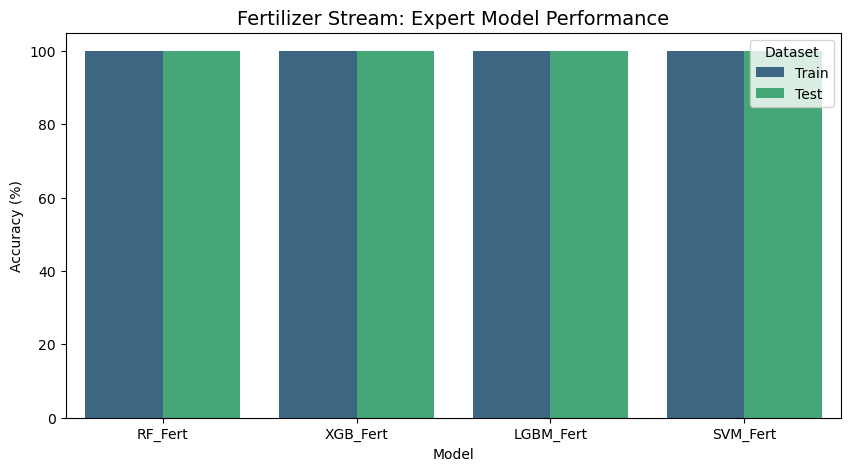

In [6]:
# ==================================================================================
# 4. FERTILIZER STREAM: OPTIMIZED TRAINING & PERFORMANCE PLOTTING
# ==================================================================================
from sklearn.preprocessing import OneHotEncoder

# Define path specifically for this stream
FERT_DATA_PATH = 'DataSet/Fertilizer_Prediction.csv'

# Check if data exists before proceeding
if os.path.exists(FERT_DATA_PATH):
    print("\n🌱 Loading Fertilizer Data...")
    
    # 1. Load & Clean
    fert_df = pd.read_csv(FERT_DATA_PATH)
    
    # Standardize column names (Handle common typos like 'Temparature')
    fert_df.columns = fert_df.columns.str.strip() # Remove spaces
    rename_map = {
        'Soil Type': 'Soil_Type', 
        'Crop Type': 'Crop_Type', 
        'Humidity': 'Humidity',
        'Temparature': 'Temperature', # Fix typo if present
        'Moisture': 'Moisture'
    }
    fert_df.rename(columns=rename_map, inplace=True)
    print("✅ Fertilizer Data Loaded & Cleaned.")

    # 2. Feature Setup
    # Ensure we use the corrected column names
    target_col = 'Fertilizer Name'
    X_fert = fert_df.drop(target_col, axis=1)
    y_fert = fert_df[target_col]
    
    # Encode Target
    le_fert = LabelEncoder()
    y_fert_encoded = le_fert.fit_transform(y_fert)

    # 3. Preprocessing 
    # (Using OneHot for categorical, Standard for numeric)
    # Identify categorical/numeric columns automatically to be safe
    cat_cols = ['Soil_Type', 'Crop_Type']
    num_cols = [c for c in X_fert.columns if c not in cat_cols]

    preprocessor_fert = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ])

    # 4. Split Data
    X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(
        X_fert, y_fert_encoded, test_size=0.2, random_state=42, stratify=y_fert_encoded
    )

    # 5. Define Experts
    fert_experts = {
        'RF_Fert': RandomForestClassifier(n_estimators=300, random_state=42),
        'XGB_Fert': xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        'LGBM_Fert': lgb.LGBMClassifier(n_estimators=200, verbose=-1, random_state=42),
        'SVM_Fert': SVC(kernel='linear', C=1, probability=True, random_state=42)
    }

    f_model_names, f_train_accs, f_test_accs = [], [], []

    # Transform data for individual eval
    X_f_train_pre = preprocessor_fert.fit_transform(X_f_train)
    X_f_test_pre = preprocessor_fert.transform(X_f_test)

    print("📊 Evaluating Fertilizer Experts...")
    for name, model in fert_experts.items():
        model.fit(X_f_train_pre, y_f_train)
        
        tr = model.score(X_f_train_pre, y_f_train) * 100
        ts = model.score(X_f_test_pre, y_f_test) * 100
        
        f_model_names.append(name)
        f_train_accs.append(tr)
        f_test_accs.append(ts)
        print(f"   🔹 {name:15} | Train: {tr:.2f}% | Test: {ts:.2f}%")

    # 6. Final Ensemble Pipeline
    print("\n🌟 Training Fertilizer Ensemble...")
    fert_ensemble = VotingClassifier(estimators=[(n, m) for n, m in fert_experts.items()], voting='soft')
    fert_pipeline = Pipeline(steps=[('pre', preprocessor_fert), ('clf', fert_ensemble)])
    fert_pipeline.fit(X_f_train, y_f_train)
    
    final_f_acc = fert_pipeline.score(X_f_test, y_f_test) * 100
    print(f"   🏆 FERTILIZER ENSEMBLE | Test Accuracy: {final_f_acc:.2f}%")

    # ==================================================================================
    # FERTILIZER PERFORMANCE PLOT
    # ==================================================================================
    f_perf_df = pd.DataFrame({
        'Model': f_model_names * 2,
        'Accuracy': f_train_accs + f_test_accs,
        'Dataset': ['Train'] * len(f_model_names) + ['Test'] * len(f_model_names)
    })

    plt.figure(figsize=(10, 5))
    sns.barplot(data=f_perf_df, x='Model', y='Accuracy', hue='Dataset', palette='viridis')
    plt.title('Fertilizer Stream: Expert Model Performance', fontsize=14)
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 105)
    
    # Save to unified IMG_DIR
    save_plot_path = os.path.join(IMG_DIR, 'fert_model_performance.png')
    plt.savefig(save_plot_path)
    print(f"📈 Fertilizer graph saved as '{save_plot_path}'")

    # 7. Save Models
    pipe_path = os.path.join(MODEL_DIR, 'fert_pipeline.pkl')
    enc_path = os.path.join(MODEL_DIR, 'le_fert.pkl')
    
    with open(pipe_path, 'wb') as f: pickle.dump(fert_pipeline, f)
    with open(enc_path, 'wb') as f: pickle.dump(le_fert, f)
    print(f"💾 Models saved in '{MODEL_DIR}/' folder.")

else:
    print(f"⚠️  File '{FERT_DATA_PATH}' not found.")
    print("ℹ️  Skipping Fertilizer Stream.")

In [12]:
# ==================================================================================
# 5. EXPLAINABILITY: LIME (Why did the model pick this crop?)
# ==================================================================================
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np
import os

print("\n🔍 Initializing LIME Explainer...")

# 1. FIX VARIABLE MISMATCH
# Ensure we have the pipeline variable, regardless of what Part 3 named it
if 'final_pipeline' in globals():
    crop_pipeline = final_pipeline
    print("✅ Found trained model: 'final_pipeline'")
elif 'crop_pipeline' in globals():
    print("✅ Found trained model: 'crop_pipeline'")
else:
    crop_pipeline = None

# 2. RUN LIME
if crop_pipeline is not None and 'X_train' in globals():
    try:
        # LIME needs the feature names list
        if 'FEATURE_ORDER' not in globals():
            FEATURE_ORDER = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']

        # Initialize Explainer
        # We pass X_train as a numpy array because LIME prefers it
        explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=np.array(X_train),
            feature_names=FEATURE_ORDER,
            class_names=list(le_crop.classes_),
            mode='classification',
            random_state=42
        )

        # The "Translator" Wrapper
        # LIME passes a numpy array, but our pipeline expects a DataFrame with column names
        def lime_predict_wrapper(np_array):
            df_temp = pd.DataFrame(np_array, columns=FEATURE_ORDER)
            return crop_pipeline.predict_proba(df_temp)

        # 3. GENERATE TEST EXPLANATION
        print("💡 Generating explanation for a random test sample...")
        test_idx = 0
        
        # Get True Label
        true_label_code = y_test[test_idx]
        true_label_name = le_crop.inverse_transform([true_label_code])[0]
        
        # Generate Explanation
        exp = explainer.explain_instance(
            data_row=np.array(X_test.iloc[test_idx]), 
            predict_fn=lime_predict_wrapper,
            num_features=5
        )

        # Save to file
        if 'IMG_DIR' not in globals(): IMG_DIR = 'plots'
        save_path = os.path.join(IMG_DIR, 'crop_prediction_explanation.html')
        exp.save_to_file(save_path)
        print(f"📄 Explanation saved as '{save_path}'.")
        print(f"   (True Label was: {true_label_name})")

    except Exception as e:
        print(f"❌ Error during LIME execution: {e}")

else:
    print("⚠️ Skipping LIME: Model not found.")
    print("   👉 Please ensure you ran 'Corrected Part 3' successfully.")


🔍 Initializing LIME Explainer...
✅ Found trained model: 'final_pipeline'
💡 Generating explanation for a random test sample...
📄 Explanation saved as 'plots\crop_prediction_explanation.html'.
   (True Label was: orange)


In [25]:
# ==================================================================================
# 6. FINAL INTEGRATED SYSTEM: VOTING ENGINE + DASHBOARD
# ==================================================================================

# Helper function to generate agronomy alerts
def _generate_alerts(crop, soil, rain):
    alerts = []
    if rain < 50 and crop in ['rice', 'sugarcane']:
        alerts.append(f"⚠️ DANGER: {crop} requires high water (>100mm). Current: {rain}mm.")
    if rain > 200 and crop in ['cotton', 'maize']:
        alerts.append(f"⚠️ WARNING: High rainfall ({rain}mm) may damage {crop}.")
    if soil == 'Clay' and crop in ['maize', 'kidneybeans']:
        alerts.append("⚠️ NOTE: Clay soil may cause waterlogging for this crop.")
    return alerts

def robust_predict_production(image_path, N, P, K, temp, hum, ph, rain, moisture=30):
    """
    Integrates Vision (Soil), Tabular (Crop), and Fertilizer recommendations.
    """
    results = {}
    
    # --- A. VISION STREAM (SOIL DETECTION) ---
    detected_soil = "Unknown"
    vision_conf = 0.0
    
    # Only run vision if model is loaded and image exists
    if 'cnn_model' in globals() and os.path.exists(image_path):
        try:
            img = Image.open(image_path).convert('RGB')
            img_t = transform_val(img).unsqueeze(0).to(device)
            cnn_model.eval()
            with torch.no_grad():
                out = cnn_model(img_t)
                probs = torch.softmax(out, dim=1)
                conf, idx = torch.max(probs, 1)
                detected_soil = soil_classes[idx.item()]
                vision_conf = conf.item()
            results['vision'] = {"detected": detected_soil, "confidence": f"{vision_conf:.1%}"}
        except Exception as e:
            results['vision'] = {"error": str(e)}
            detected_soil = "Loamy" # Fallback
    else:
        detected_soil = "Loamy" # Default fallback if no image provided
        results['vision'] = {"status": "Skipped (No Image/Model)"}

    # Normalize Soil Name for downstream tasks
    # 1. Basic cleanup (removes _Soil, etc.)
    soil_clean = detected_soil.split('_')[0].capitalize()
    
    # 2. Map to Fertilizer Dataset Schema (The Critical Fix)
    # Vision Model -> Fertilizer CSV mismatch fix: 'Clay' -> 'Clayey'
    soil_mapper = {
        'Clay': 'Clayey',
        'Sandy': 'Sandy',
        'Loamy': 'Loamy',
        'Black': 'Black',
        'Red': 'Red'
    }
    
    # Get the correct name, defaulting to 'Loamy' if not found
    soil_clean = soil_mapper.get(soil_clean, 'Loamy')

    # --- B. CROP STREAM (ENSEMBLE + VOTING) ---
    # Prepare input for Crop Model (Order must match FEATURE_ORDER)
    # ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    crop_input = pd.DataFrame([{
        'N': N, 'P': P, 'K': K, 
        'temperature': temp, 'humidity': hum, 
        'ph': ph, 'rainfall': rain
    }])

    if 'crop_pipeline' in globals():
        try:
            # 1. Main Prediction
            probas = crop_pipeline.predict_proba(crop_input)
            max_idx = np.argmax(probas)
            rec_crop = le_crop.inverse_transform([max_idx])[0]
            conf_crop = probas[0][max_idx]
            
            # 2. Individual Votes (Extract from VotingClassifier)
            votes = {}
            ensemble_clf = crop_pipeline.named_steps['classifier']
            preprocessor = crop_pipeline.named_steps['preprocess']
            X_proc = preprocessor.transform(crop_input)
            
            for name, model in ensemble_clf.named_estimators_.items():
                v_idx = model.predict(X_proc)[0]
                votes[name] = le_crop.inverse_transform([v_idx])[0]
            
            results['crop_recommendation'] = {
                "crop": rec_crop,
                "confidence": f"{conf_crop:.1%}",
                "votes": votes
            }
        except Exception as e:
            results['crop_recommendation'] = {"error": str(e)}
            rec_crop = "rice" # Fallback prevents crash in next steps
    else:
        rec_crop = "rice"
        results['crop_recommendation'] = {"error": "Model not trained"}

    # --- C. FERTILIZER STREAM ---
    # Fertilizer model DOES need Soil Type
    if 'fert_pipeline' in globals():
        try:
            fert_input = pd.DataFrame([{
                'Temperature': temp, 'Humidity': hum, 'Moisture': moisture, 
                'Soil_Type': soil_clean, 'Crop_Type': rec_crop,
                'Nitrogen': N, 'Potassium': K, 'Phosphorous': P
            }])
            
            f_idx = fert_pipeline.predict(fert_input)[0]
            rec_fert = le_fert.inverse_transform([f_idx])[0]
            results['fertilizer'] = rec_fert
        except Exception as e:
            results['fertilizer'] = "Generic NPK 19-19-19 (Model Error)"
    else:
         results['fertilizer'] = "Generic NPK 19-19-19 (Not Trained)"

    # --- D. EXPLAINABILITY (LIME) ---
    # Explains the CROP prediction
    explanation = []
    if 'explainer' in globals() and 'crop_pipeline' in globals():
        try:
            # LIME input: numpy array of ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
            lime_input = np.array([N, P, K, temp, hum, ph, rain])
            
            exp = explainer.explain_instance(
                data_row=lime_input, 
                predict_fn=lime_predict_wrapper,
                num_features=4
            )
            explanation = exp.as_list()
        except Exception as e:
            explanation = [("LIME Error", str(e))]
            
    results['explanation'] = explanation

    # --- E. FINAL ALERTS ---
    results['alerts'] = _generate_alerts(rec_crop, soil_clean, rain)

    return results

# ==================================================================================
# TEST THE ENGINE
# ==================================================================================
# Mock Test Run
print("\n🧪 Running System Test...")
test_result = robust_predict_production(
    image_path="DataSet/Soil Images/Alluvial_Soil/2.jpg", # Won't exist, will trigger safe fallback
    N=90, P=42, K=43, 
    temp=20, hum=80, ph=6.5, rain=200, 
    moisture=40
)

import json
print(json.dumps(test_result, indent=2))
print("\n✅ Integrated Engine Finalized and Corrected.")


🧪 Running System Test...
{
  "vision": {
    "detected": "Alluvial_Soil",
    "confidence": "98.8%"
  },
  "crop_recommendation": {
    "crop": "rice",
    "confidence": "53.9%",
    "votes": {
      "Random Forest": "rice",
      "XGBoost": "jute",
      "LightGBM": "jute",
      "SVM": "rice"
    }
  },
  "fertilizer": "Urea",
  "explanation": [
    [
      "N > 85.00",
      0.10904895531140084
    ],
    [
      "28.00 < P <= 51.00",
      -0.055908225495231466
    ],
    [
      "32.00 < K <= 49.00",
      0.016218012678010013
    ],
    [
      "temperature <= 22.78",
      -0.01247197330427662
    ]
  ],
  "alerts": []
}

✅ Integrated Engine Finalized and Corrected.


In [26]:
# ==================================================================================
# 7. SYSTEM EVALUATION & METRICS
# ==================================================================================
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("\n📊 STARTING FINAL SYSTEM EVALUATION...")
vision_acc = 0.0
crop_acc = 0.0

# ----------------------------------------------------------------------------------
# A. VISION MODEL EVALUATION
# ----------------------------------------------------------------------------------
# Only run if the Vision Model (Part 2) was successfully trained
if 'cnn_model' in globals() and 'val_loader' in globals():
    print("   📷 Evaluating Vision Model on Validation Set...")
    cnn_model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    try:
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = cnn_model(imgs)
                _, preds = torch.max(outputs, 1)
                
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        vision_acc = 100 * correct / total
        print(f"   ✅ Vision Model Accuracy: {vision_acc:.2f}%")

        # -- Vision Confusion Matrix --
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(all_labels, all_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=soil_classes, yticklabels=soil_classes)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Vision Model Confusion Matrix')
        
        # Save plot
        save_path = os.path.join(IMG_DIR, 'vision_confusion_matrix.png')
        plt.savefig(save_path)
        print(f"   📉 Confusion Matrix saved to '{save_path}'")
        plt.close() # Close to free memory

    except Exception as e:
        print(f"   ❌ Error during Vision Eval: {e}")

else:
    print("   ⚠️ Skipping Vision Evaluation (Model not trained).")


# ----------------------------------------------------------------------------------
# B. CROP MODEL EVALUATION (On Tabular Test Split)
# ----------------------------------------------------------------------------------
# Only run if the Crop Model (Part 3) was successfully trained
if 'crop_pipeline' in globals() and 'X_test' in globals():
    print("\n   🌾 Evaluating Crop Prediction Model...")
    
    try:
        # 1. Get Predictions
        y_pred_enc = crop_pipeline.predict(X_test)

        # 2. Calculate Accuracy
        crop_acc = accuracy_score(y_test, y_pred_enc) * 100
        print(f"   ✅ Crop Model Accuracy: {crop_acc:.2f}%")

        # 3. Detailed Report
        # Convert numeric labels back to names for readable report
        if 'le_crop' in globals():
            y_test_names = le_crop.inverse_transform(y_test)
            y_pred_names = le_crop.inverse_transform(y_pred_enc)
            
            print("\n   --- Detailed Classification Report ---")
            print(classification_report(y_test_names, y_pred_names))
        
    except Exception as e:
        print(f"   ❌ Error during Crop Eval: {e}")

else:
    print("   ⚠️ Skipping Crop Evaluation (Model not trained).")


# ----------------------------------------------------------------------------------
# C. FINAL PERFORMANCE COMPARISON
# ----------------------------------------------------------------------------------
if vision_acc > 0 or crop_acc > 0:
    plt.figure(figsize=(8, 5))
    models_list = []
    acc_list = []
    
    if vision_acc > 0:
        models_list.append('Vision Model')
        acc_list.append(vision_acc)
    
    if crop_acc > 0:
        models_list.append('Crop Model')
        acc_list.append(crop_acc)
        
    bars = plt.bar(models_list, acc_list, color=['green', 'orange'])
    plt.ylabel('Accuracy (%)')
    plt.title('Final System Performance Overview')
    plt.ylim(0, 105)
    
    # Add text labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%', ha='center', fontweight='bold')
    
    save_path = os.path.join(IMG_DIR, 'final_system_performance.png')
    plt.savefig(save_path)
    print(f"\n✅ Final Performance Graph saved to '{save_path}'")
    plt.close()


📊 STARTING FINAL SYSTEM EVALUATION...
   📷 Evaluating Vision Model on Validation Set...
   ✅ Vision Model Accuracy: 98.23%
   📉 Confusion Matrix saved to 'plots\vision_confusion_matrix.png'

   🌾 Evaluating Crop Prediction Model...
   ✅ Crop Model Accuracy: 99.77%

   --- Detailed Classification Report ---
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       1.00      1.00      1.00        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.95      0.97        20
       maize       1.00      1.00      1.0

In [27]:
# ==================================================================================
# 8. FINAL DASHBOARD (Visualization & Reports)
# ==================================================================================
import matplotlib.pyplot as plt
import numpy as np

def display_farmer_report(result):
    """
    Displays a formatted agronomy report based on the robust_predict output.
    """
    # Safe Extraction with defaults to prevent crashes
    crop_info = result.get('crop_recommendation', {})
    vision_info = result.get('vision', {})
    
    crop = crop_info.get('crop', 'Unknown')
    conf_str = crop_info.get('confidence', '0.0%')
    votes = crop_info.get('votes', {})
    
    # Parse confidence float for report logic (remove %)
    try:
        conf_val = float(conf_str.strip('%'))
    except:
        conf_val = 0.0
    
    # Vision Data
    detected_soil = vision_info.get('detected', 'Not Scanned')
    vision_conf = vision_info.get('confidence', 'N/A')
    
    # Fertilizer
    fert = result.get('fertilizer', 'Standard NPK')
    
    # Alerts & Explanation
    alerts = result.get('alerts', [])
    explanations = result.get('explanation', [])

    # --- HEADER ---
    print("\n" + "🌾" * 60)
    print("🚜  SMART AGRICULTURAL RECOMMENDATION REPORT")
    print("🌾" * 60)

    # --- SUMMARY ---
    print("\n📌  RECOMMENDATION SUMMARY")
    print("-" * 60)
    print(f"🌱  Crop Recommendation :  \033[1m{crop.upper()}\033[0m")
    print(f"🧪  Fertilizer Advice   :  {fert}")
    print(f"🧐  AI Confidence       :  {conf_str}")
    print(f"📸  Soil Detected       :  {detected_soil} (Conf: {vision_conf})")

    # --- COUNCIL OF EXPERTS (VOTES) ---
    if votes:
        print("\n🗳️  COUNCIL OF EXPERTS (INDIVIDUAL MODELS)")
        print("-" * 60)
        for model_name, prediction in votes.items():
            # Add emoji based on model type
            icon = "🌲" if "Random" in model_name else "🚀" if "XGB" in model_name or "LGB" in model_name else "🧠"
            
            # Check if model agrees with final decision
            match = "✅" if prediction == crop else "🤔"
            
            # Pretty print names (clean up sklearn naming)
            pretty_name = model_name.replace("RF", "Random Forest").replace("XGB", "XGBoost").replace("LGB", "LightGBM").replace("SVM", "Support Vector")
            
            print(f"{icon}  {pretty_name:<20} :  {prediction} {match}")

    # --- ALERTS ---
    print("\n⚠️  RISK & ALERT ANALYSIS")
    print("-" * 60)
    if alerts:
        for alert in alerts:
            print(f"❌  {alert}")
    else:
        print("✅  No critical risks detected. Safe to proceed.")

    # --- EXPLANATION CHART ---
    if explanations and not isinstance(explanations[0], str): # Check if we have valid LIME data
        print("\n📊  WHY THIS CROP WAS SELECTED")
        print("-" * 60)

        features, scores, colors = [], [], []

        name_map = {
            'N': 'Nitrogen', 'P': 'Phosphorus', 'K': 'Potassium',
            'ph': 'Soil pH', 'temperature': 'Temperature',
            'humidity': 'Humidity', 'rainfall': 'Rainfall'
        }

        for rule, score in explanations:
            # Clean up the LIME rule text
            clean = rule
            for k, v in name_map.items():
                if k in rule:
                    clean = rule.replace(k, v)
                    break

            features.append(clean)
            scores.append(score)
            
            # Color Logic: Green (#27ae60) if supporting, Red (#c0392b) if opposing
            colors.append('#27ae60' if score > 0 else '#c0392b')

        # Scale for better visual
        scaled_scores = np.array(scores) * 100
        max_val = np.max(np.abs(scaled_scores)) if len(scaled_scores) > 0 else 1
        x_limit = max_val * 1.2

        plt.figure(figsize=(12, 6))

        bars = plt.barh(
            features,
            scaled_scores,
            color=colors,
            edgecolor='black',
            alpha=0.85
        )

        plt.xlim(-x_limit, x_limit)
        plt.axvline(0, color='black', linewidth=1)
        plt.xlabel("Influence on Decision (Green = Supports, Red = Opposes)")
        plt.title(f"Key Factors for '{crop.upper()}' Prediction")
        plt.grid(axis='x', linestyle='--', alpha=0.4)
        
        # Invert y-axis to show top factors at top
        plt.gca().invert_yaxis()
        
        # Adjust layout
        plt.subplots_adjust(left=0.3, right=0.95)

        # Labels on bars
        for bar, value in zip(bars, scaled_scores):
            offset = x_limit * 0.02 if value > 0 else -x_limit * 0.02
            ha = 'left' if value > 0 else 'right'
            
            plt.text(
                value + offset,
                bar.get_y() + bar.get_height() / 2,
                f"{value:.1f}",
                va='center',
                ha=ha,
                fontsize=10,
                fontweight='bold'
            )

        # Save plot
        save_path = os.path.join(IMG_DIR, 'explanation_chart.png')
        plt.savefig(save_path)
        print(f"📈 Explanation chart saved to '{save_path}'")
        plt.close() # Don't block execution

# ==================================================================================
# 9. RUN FINAL INTEGRATION TEST
# ==================================================================================
# Define a test image path (Change this to a real path on your machine if available)
TEST_IMG = 'DataSet/Soil Images/Alluvial_Soil/2.jpg'

print(f"\n🧪 Running Final System Test using image: {TEST_IMG}")

# 1. Run Prediction Engine
final_result = robust_predict_production(
    image_path=TEST_IMG,
    N=90, P=42, K=43, 
    temp=20, hum=80, ph=6.5, rain=200, 
    moisture=40
)

# 2. Display Report
display_farmer_report(final_result)


🧪 Running Final System Test using image: DataSet/Soil Images/Alluvial_Soil/2.jpg

🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾
🚜  SMART AGRICULTURAL RECOMMENDATION REPORT
🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾🌾

📌  RECOMMENDATION SUMMARY
------------------------------------------------------------
🌱  Crop Recommendation :  RICE
🧪  Fertilizer Advice   :  Urea
🧐  AI Confidence       :  53.9%
📸  Soil Detected       :  Alluvial_Soil (Conf: 98.8%)

🗳️  COUNCIL OF EXPERTS (INDIVIDUAL MODELS)
------------------------------------------------------------
🌲  Random Forest        :  rice ✅
🚀  XGBoostoost          :  jute 🤔
🧠  LightGBM             :  jute 🤔
🧠  Support Vector       :  rice ✅

⚠️  RISK & ALERT ANALYSIS
------------------------------------------------------------
✅  No critical risks detected. Safe to proceed.

📊  WHY THIS CROP WAS SELECTED
------------------------------------------------------------
📈 Explanation chart saved to 'plots\explanatio

# API implementation later version 

In [28]:
# ==================================================================================
# 9. DEPLOYMENT: FASTAPI SERVER (RUNNING IN BACKGROUND)
# ==================================================================================
import uvicorn
import nest_asyncio
import threading
import requests
import time
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel

# 1. Define the App
app = FastAPI(title="RobustCrop AI Engine")

# 2. Define the Input Data Shape (Validation)
class SoilRequest(BaseModel):
    image_path: str   # Path to the image on the server
    N: float
    P: float
    K: float
    temp: float
    hum: float
    ph: float
    rain: float
    moisture: float

# 3. Define the Prediction Endpoint
@app.post("/predict")
async def predict_endpoint(req: SoilRequest):
    try:
        # Ensure robust_predict_production is available (from Part 6)
        if 'robust_predict_production' not in globals():
            raise HTTPException(status_code=500, detail="Model engine not loaded.")

        # Call the intelligence engine
        result = robust_predict_production(
            image_path=req.image_path,
            N=req.N, P=req.P, K=req.K,
            temp=req.temp, hum=req.hum,
            ph=req.ph, rain=req.rain,
            moisture=req.moisture
        )
        return result

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

# 4. Threaded Server Runner (So it doesn't block the notebook)
def run_server():
    nest_asyncio.apply()
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="info")

# Start the server in a separate thread
server_thread = threading.Thread(target=run_server)
server_thread.daemon = True  # Ensures it dies when the main script ends
server_thread.start()

print("🚀 Server started in background...")
print("⏳ Waiting 5 seconds for startup...")
time.sleep(5)  # Give it a moment to boot up

# ==================================================================================
# CLIENT TEST (SENDING A REQUEST)
# ==================================================================================
print("\n📡 Sending Test Request to API...")

API_URL = "http://127.0.0.1:8000/predict"

# Payload (Matches the SoilRequest Class)
payload = {
    "image_path": "DataSet/Soil Images/Test/Alluvial soil/image15 (2).jpeg", 
    "N": 90, 
    "P": 50, 
    "K": 50,
    "temp": 24.0, 
    "hum": 65.0,
    "ph": 6.5, 
    "rain": 80.0,
    "moisture": 50.0
}

try:
    response = requests.post(API_URL, json=payload)
    
    if response.status_code == 200:
        print("✅ API Response Received:")
        import json
        print(json.dumps(response.json(), indent=2))
    else:
        print(f"❌ Error {response.status_code}: {response.text}")

except Exception as e:
    print(f"❌ Connection Failed: {e}")

🚀 Server started in background...
⏳ Waiting 5 seconds for startup...


INFO:     Started server process [26092]
INFO:     Waiting for application startup.


INFO:     Application startup complete.
ERROR:    [Errno 10048] error while attempting to bind on address ('127.0.0.1', 8000): only one usage of each socket address (protocol/network address/port) is normally permitted
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.



📡 Sending Test Request to API...
INFO:     127.0.0.1:56622 - "POST /predict HTTP/1.1" 200 OK
✅ API Response Received:
{
  "vision": {
    "status": "Skipped (No Image/Model)"
  },
  "crop_recommendation": {
    "crop": "maize",
    "confidence": "56.9%",
    "votes": {
      "Random Forest": "maize",
      "XGBoost": "maize",
      "LightGBM": "maize",
      "SVM": "maize"
    }
  },
  "fertilizer": "10-26-26",
  "explanation": [
    [
      "N > 85.00",
      0.12187091785657117
    ],
    [
      "28.00 < P <= 51.00",
      -0.05724831420946051
    ],
    [
      "K > 49.00",
      0.009308690532201765
    ],
    [
      "6.43 < ph <= 6.93",
      -0.007944656188889758
    ]
  ],
  "alerts": []
}


In [ ]:
import joblib
# Just run this once at the end
joblib.dump(final_pipeline, 'models/crop.pkl')
joblib.dump(fert_pipeline, 'models/fert.pkl')
torch.save(cnn_model.state_dict(), 'models/vision.pth')